# Imports

In [124]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import re
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn import metrics

from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
import joblib
import matplotlib.pyplot as plt

try:
    import cPickle as pickle
except ImportError: 
    import pickle


In [39]:
# Downloading punkt and wordnet from NLTK
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/laptopcheckout/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/laptopcheckout/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/laptopcheckout/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/laptopcheckout/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [40]:
#Loading the Data into DataFrame
df= pd.read_csv("IMDB_Dataset.csv")

In [41]:
print("-------------------------------")
print("\nCheck the dataframe \n",df.head())
print("-------------------------------")
print("\nCheck the shape of dataframe \n",df.shape)
print("-------------------------------")

-------------------------------

Check the dataframe 
                                               review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
-------------------------------

Check the shape of dataframe 
 (50000, 2)
-------------------------------


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


# Exploratory Data Analysis

In [43]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [44]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

/Users/laptopcheckout/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Positive reviews are 25000 and negative reviews are 25000 of total 50000 


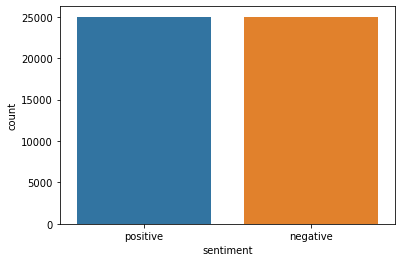

In [45]:
#taking count of negative reviews
negative_reviews = len(df[df['sentiment']=='negative'])
positive_reviews = len(df) - negative_reviews
sns.countplot(df['sentiment'])
print('Positive reviews are {} and negative reviews are {} of total {} '.format(positive_reviews,negative_reviews,len(df)))

# Data Pre-Processing

Text cleaning and preparation

In [46]:
#replacing "'s'","\r","\n"
# " when quoting text

df['R_1'] = (((((df['review'].replace("\r", " ", regex=True)).replace("\n", " ", regex=True)).replace("    ", " ")).replace('"', '',  regex=True)).replace("\t", " ", regex=True))
df['R_2'] =df['R_1'].str.replace('(<br />|\d+\.)','').str.split().agg(" ".join)
df['R_3'] = df['R_2'].str.lower()
df['R_3'] = df['R_3'].replace("'s", "", regex=True)
df['R_3']

/var/folders/mn/lfwc3yt10wjflgrbsc_29v580000gs/T/ipykernel_16755/1088717685.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['R_2'] =df['R_1'].str.replace('(<br />|\d+\.)','').str.split().agg(" ".join)


0        one of the other reviewers has mentioned that ...
1        a wonderful little production. the filming tec...
2        i thought this was a wonderful way to spend ti...
3        basically there a family where a little boy (j...
4        petter mattei love in the time of money is a v...
                               ...                        
49995    i thought this movie did a down right good job...
49996    bad plot, bad dialogue, bad acting, idiotic di...
49997    i am a catholic taught in parochial elementary...
49998    i'm going to have to disagree with the previou...
49999    no one expects the star trek movies to be high...
Name: R_3, Length: 50000, dtype: object

In [47]:
# Removing punctuation
punctuation_signs = list("?:!.,;'")
df['R_4'] = df['R_3']
for punct_sign in punctuation_signs:
    df['R_4'] = df['R_4'].str.replace(punct_sign, '',regex=True)
df['R_4']

0        one of the other reviewers has mentioned that ...
1        a wonderful little production the filming tech...
2        i thought this was a wonderful way to spend ti...
3        basically there a family where a little boy (j...
4        petter mattei love in the time of money is a v...
                               ...                        
49995    i thought this movie did a down right good job...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    i am a catholic taught in parochial elementary...
49998    im going to have to disagree with the previous...
49999    no one expects the star trek movies to be high...
Name: R_4, Length: 50000, dtype: object

# Lemmatization

In [48]:
# Saving the lemmatizer into an object
wordnet_lemmatizer = WordNetLemmatizer()

In [49]:
nrows = len(df)
lemmatized_text_list = []

for row in range(0, nrows):
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = df.loc[row]['R_4']
    text_words = text.split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)

In [50]:
df['R_5'] = lemmatized_text_list
df['R_5']

0        one of the other reviewers have mention that a...
1        a wonderful little production the film techniq...
2        i think this be a wonderful way to spend time ...
3        basically there a family where a little boy (j...
4        petter mattei love in the time of money be a v...
                               ...                        
49995    i think this movie do a down right good job it...
49996    bad plot bad dialogue bad act idiotic direct t...
49997    i be a catholic teach in parochial elementary ...
49998    im go to have to disagree with the previous co...
49999    no one expect the star trek movies to be high ...
Name: R_5, Length: 50000, dtype: object

In [51]:
# Loading the stop words in english
stop_words = set(stopwords.words("english"))
#stop_words = list(stopwords.words('english'))

In [52]:
df['R_6'] = df['R_5']

for stop_word in stop_words:

    regex_stopword = r"\b" + stop_word + r"\b"
    df['R_6'] = df['R_6'].str.replace(regex_stopword, '')

/var/folders/mn/lfwc3yt10wjflgrbsc_29v580000gs/T/ipykernel_16755/1513237176.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['R_6'] = df['R_6'].str.replace(regex_stopword, '')


In [53]:
df.head(1)

,review,sentiment,R_1,R_2,R_3,R_4,R_5,R_6
0,One of the other reviewers has mentioned that ...,positive,One of the other reviewers has mentioned that ...,One of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,one of the other reviewers have mention that a...,one reviewers mention watch 1 oz episod...


In [72]:
sentences=df['R_6']
le=LabelEncoder()
df['sentiment']= le.fit_transform(df['sentiment'])

# Splitting Data

In [73]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1,2))
matrix_count = tfidf.fit_transform(df.R_6)

In [84]:
X_train, X_test, Y_train, Y_test = train_test_split(matrix_count, df.sentiment, test_size=0.20, random_state=2)

# Evaluating the model

In [105]:
M_NB = MultinomialNB()
MNB=M_NB.fit(X_train, Y_train)
print(MNB)

MultinomialNB()
MultinomialNB()


In [108]:
mnb_tfidf_predict=M_NB.predict(X_test)
print(mnb_tfidf_predict)

[0 0 1 ... 0 1 1]


In [119]:
accuracy_score = metrics.accuracy_score(M_NB.predict(X_test), Y_test)
print("accuracy using TF-IDF "+str('{:04.2f}'.format(accuracy_score*100))+" %")

accuracy using TF-IDF 88.87 %


In [110]:
c_Report= classification_report(Y_test, M_NB.predict(X_test),target_names=['Negative','Positive'])
print("The Classification Report: \n",c_Report )
cf_matrix=confusion_matrix(Y_test, M_NB.predict(X_test))
print("The Confusion Matrix: \n", cf_matrix)

The Classification Report: 
               precision    recall  f1-score   support

    Negative       0.89      0.89      0.89      4979
    Positive       0.89      0.89      0.89      5021

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

The Confusion Matrix: 
 [[4442  537]
 [ 576 4445]]


In [60]:
L_SVC = LinearSVC()
L_SVC.fit(X_train, Y_train)
accuracy_score = metrics.accuracy_score(L_SVC.predict(X_test), Y_test)
print("Linear SVC accuracy = " + str('{:04.2f}'.format(accuracy_score*100))+" %")
print("Classification Report: \n", classification_report(Y_test, L_SVC.predict(X_test),target_names=['Negative','Positive']))
print("Confusion Matrix: \n", confusion_matrix(Y_test, L_SVC.predict(X_test)))

Linear SVC accuracy = 91.09 %
Classification Report: 
               precision    recall  f1-score   support

    Negative       0.92      0.90      0.91      4979
    Positive       0.90      0.92      0.91      5021

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

Confusion Matrix: 
 [[4482  497]
 [ 394 4627]]


In [61]:
predictions=L_SVC.predict(X_test)

/Users/laptopcheckout/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

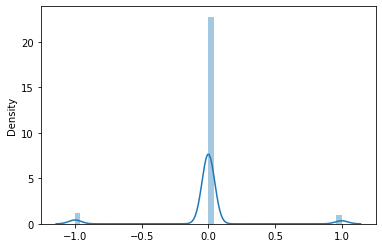

In [62]:
sns.distplot(Y_test-predictions)

In [66]:
sentences=df['R_6']
le=LabelEncoder()
df['sentiment']= le.fit_transform(df['sentiment'])

In [71]:
df['sentiment']

0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64

(-0.5, 799.5, 799.5, -0.5)

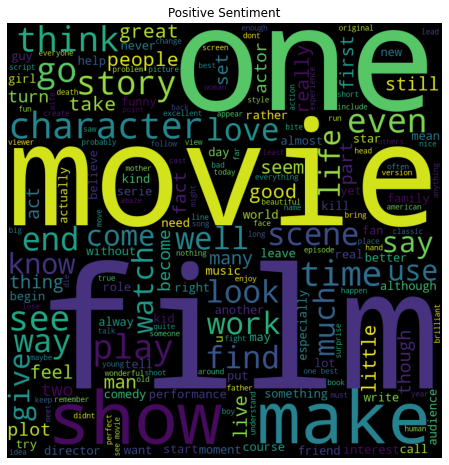

In [103]:
pos_text=' '.join(map(str,sentences[df['sentiment']==1]))
neg_text=' '.join(map(str,sentences[df['sentiment']==0]))
  

wordcloud_positive = WordCloud(width = 800, height = 800, 
                background_color ='black',  
                min_font_size = 10).generate(pos_text) 
positive_words=wordcloud_positive.generate(pos_text)
plt.figure(figsize=(8,8))
plt.imshow(positive_words)
plt.title('Positive Sentiment')
plt.axis('off')


(-0.5, 799.5, 799.5, -0.5)

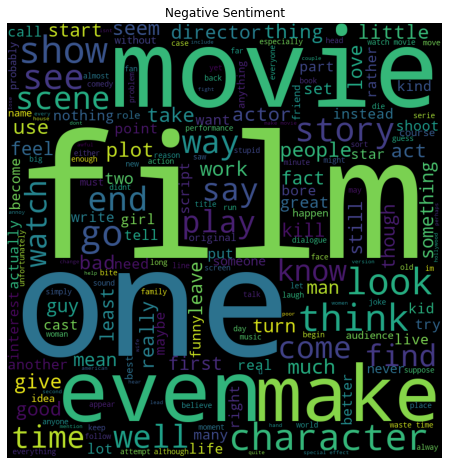

In [116]:
wordcloud_negative = WordCloud(width = 800, height = 800, 
                background_color ='black',  
                min_font_size = 10).generate_from_text(neg_text) 
negative_words=wordcloud_negative.generate(neg_text)
plt.figure(figsize=(8,8))
plt.imshow(negative_words)
plt.title('Negative Sentiment')
plt.axis('off')

In [126]:
#creating pickle file
#joblib.dump(L_SVC, 'Linear_SVC_Model.pkl')

['Linear_SVC_Model.pkl']

In [ ]:
#Linear_SVC_Model = open('Linear_SVC_Model.pkl','rb')
#L_SVC = joblib.load(Linear_SVC_Model)